## Load documents with IDs

In [ ]:
# import requests
# import pandas as pd

# url_prefix = 'https://raw.githubusercontent.com/DataTalksClub/llm-zoomcamp/main/03-evaluation/'
# docs_url = url_prefix + 'search_evaluation/documents-with-ids.json'
# documents = requests.get(docs_url).json()

# ground_truth_url = url_prefix + 'search_evaluation/ground-truth-data.csv'
# df_ground_truth = pd.read_csv(ground_truth_url)
# df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
# ground_truth = df_ground_truth.to_dict(orient='records')

In [1]:
import requests
import os
import json
import pandas as pd

In [2]:
with open('documents-with-ids.json', 'rt') as f_in:
    docs_raw = json.load(f_in)

documents = []

for course in docs_raw:
    # course_name = course['course']

    # for doc in course['documents']:
    #     doc['course'] = course_name
    documents.append(course)


In [3]:
documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

In [4]:
len(documents)

948

In [15]:
documents_short = documents[:10]
ids_short = [d['id'] for d in documents_short]
print(ids_short)

['c02e79ef', '1f6520ca', '7842b56a', '0bbf41ec', '63394d91', '2ed9b986', '93e2c8ed', 'a482086d', 'eb56ae98', '4292531b']


In [20]:
df_ground_truth = pd.read_csv('ground-truth-data.csv')
df_ground_truth = df_ground_truth[df_ground_truth.document.isin(ids_short)]
ground_truth = df_ground_truth.to_dict(orient='records')
len(ground_truth)

50

In [22]:
df_ground_truth.head(10)

,question,course,document
0,When does the course begin?,data-engineering-zoomcamp,c02e79ef
1,How can I get the course schedule?,data-engineering-zoomcamp,c02e79ef
2,What is the link for course registration?,data-engineering-zoomcamp,c02e79ef
3,How can I receive course announcements?,data-engineering-zoomcamp,c02e79ef
4,Where do I join the Slack channel?,data-engineering-zoomcamp,c02e79ef
5,Where can I find the prerequisites for this co...,data-engineering-zoomcamp,1f6520ca
6,How do I check the prerequisites for this course?,data-engineering-zoomcamp,1f6520ca
7,Where are the course prerequisites listed?,data-engineering-zoomcamp,1f6520ca
8,What are the requirements for joining this cou...,data-engineering-zoomcamp,1f6520ca
9,Where is the list of prerequisites for the cou...,data-engineering-zoomcamp,1f6520ca


In [ ]:
#print(list(filter(lambda d: d['id'] == '0227b872', documents)))

[{'text': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork', 'section': 'General course-related questions', 'question': 'How do I sign up?', 'course': 'machine-learning-zoomcamp', 'id': '0227b872'}]


In [45]:
doc_idx = {d['id']: d for d in documents}
#print(doc_idx['5170565b']['text'], doc_idx['5170565b']['question'], sep=' --- ')
print(f"{doc_idx['c02e79ef']['text']}\n---\n{doc_idx['c02e79ef']['question']}\n---\n{doc_idx['c02e79ef']['id']}")



The purpose of this document is to capture frequently asked technical questions
The exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1
Subscribe to course public Google Calendar (it works from Desktop only).
Register before the course starts using this link.
Join the course Telegram channel with announcements.
Don’t forget to register in DataTalks.Club's Slack and join the channel.
---
Course - When will the course start?
---
c02e79ef


## Adding hashed ID

In [7]:
import hashlib

def gen_doc_id(doc):
    doc_str = doc['course'] + doc['question'] + doc['text'][:10]
    hash_hex = hashlib.md5(doc_str.encode('utf-8')).hexdigest()
    document_id = hash_hex[:8]
    return document_id 

In [8]:
for i in documents:
    i["id"] = gen_doc_id(i)


In [9]:
documents[1]

{'text': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
 'section': 'General course-related questions',
 'question': 'Course - What are the prerequisites for this course?',
 'course': 'data-engineering-zoomcamp',
 'id': '0df8ed21'}

In [10]:
from collections import defaultdict

In [23]:
hashes = defaultdict(list)

for doc in documents:
    doc_id = doc['id']
    hashes[doc_id].append(doc)

In [13]:
len(hashes), len(documents)

(947, 948)

In [17]:
for k, v in hashes.items():
    if len(v) > 1:
        print(k)

d73e7793


In [38]:
print(hashes["d73e7793"][0]["text"]), print("-----"), print(hashes["d73e7793"][1]["text"])

They both do the same, it's just less typing from the script.
Asked by Andrew Katoch, Added by Edidiong Esu
-----
They both do the same, it's just less typing from the script.


(None, None, None)

In [2]:
with open('documents-with-ids.json', 'wt') as f_out:
    json.dump(documents, f_out)

NameError: name 'documents' is not defined

In [40]:
prompt_template = """
You emulate a student who's taking our course.
Formulate 5 questions this student might ask based on a FAQ record. The record
should contain the answer to the questions, and the questions should be complete and not too short.
If possible, use as fewer words as possible from the record. 

The record:

section: {section}
question: {question}
answer: {text}

Provide the output in parsable JSON without using code blocks:

["question1", "question2", ..., "question5"]
""".strip()

In [41]:
from groq import Groq

In [42]:
client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

In [43]:
def generate_questions(doc):
    prompt = prompt_template.format(**doc)

    response = client.chat.completions.create(
        model='llama-3.3-70b-versatile',
        messages=[{"role": "user", "content": prompt}]
    )

    json_response = response.choices[0].message.content
    return json_response

In [ ]:
# from tqdm.auto import tqdm

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# results = {}

# for doc in tqdm(documents): 
#     doc_id = doc['id']
#     if doc_id in results:
#         continue

#     questions = generate_questions(doc)
#     results[doc_id] = questions

In [ ]:
# response = generate_questions(documents[0])

In [ ]:
#json.loads(response)

['What is the initial event that will mark the beginning of the course and when is it scheduled to take place?',
 'How can I stay updated on the course schedule and important dates?',
 'What are the steps I need to take before the course officially starts?',
 'Are there any specific channels or platforms that I should join to receive announcements and stay connected with the course community?',
 'What is the procedure for registering for the course and are there any specific links or platforms that I need to use?']

## Using LLM to generate Questions

In [7]:
import pickle
import json

In [8]:
with open('results.bin', 'rb') as f_in:
    results = pickle.load(f_in)

In [9]:
results["c02e79ef"]

'["When does the course begin?", "How can I get the course schedule?", "What is the link for course registration?", "How can I receive course announcements?", "Where do I join the Slack channel?"]'

In [25]:
parsed_result = {}

for doc_id, json_questions in results.items():
    parsed_result[doc_id] = json.loads(json_questions)

In [ ]:
# json_questions = [
# r"How can I resolve the Docker error 'invalid mode: \Program Files\Git\var\lib\postgresql\data'?",
# "What should I do if I encounter an invalid mode error in Docker on Windows?",
# "What is the correct mounting path to use in Docker for PostgreSQL data on Windows?",
# "Can you provide an example of a correct Docker mounting path for PostgreSQL data?",
# r"How do I correct the mounting path error in Docker for \Program Files\Git\var\lib\postgresql\data'?"
# ]

In [ ]:
#results[doc_id] = json.dumps(json_questions,indent=2)

In [26]:
len(parsed_resulst)

947

In [12]:
with open('documents-with-ids.json', 'rt') as f_in:
    docs_raw = json.load(f_in)

documents = []
for doc in docs_raw:
    documents.append(doc)

In [16]:
print(documents[0])


{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.", 'section': 'General course-related questions', 'question': 'Course - When will the course start?', 'course': 'data-engineering-zoomcamp', 'id': 'c02e79ef'}


In [27]:
doc_index = {d['id']: d for d in documents}

In [28]:
final_results = []

for doc_id, questions in parsed_result.items():
    course = doc_index[doc_id]['course']
    for q in questions:
        final_results.append((q, course, doc_id))

In [29]:
import pandas as pd

In [30]:
df = pd.DataFrame(final_results, columns=['question', 'course', 'document'])

In [31]:
df.head()

,question,course,document
0,When does the course begin?,data-engineering-zoomcamp,c02e79ef
1,How can I get the course schedule?,data-engineering-zoomcamp,c02e79ef
2,What is the link for course registration?,data-engineering-zoomcamp,c02e79ef
3,How can I receive course announcements?,data-engineering-zoomcamp,c02e79ef
4,Where do I join the Slack channel?,data-engineering-zoomcamp,c02e79ef


In [32]:
df.to_csv('ground-truth-data.csv', index=False)

## Index data

We'll generate embeddings using [the sentence transformers](https://sbert.net/) library, if you don't have it, install it with pip:

```bash
pip install sentence-transformers
```

This is a different way of turning sentences into vectors

In [23]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
from tqdm.auto import tqdm

vectors = []

for doc in tqdm(documents_short):
    question = doc['question']
    text = doc['text']
    vector = model.encode(question + ' ' + text)
    vectors.append(vector)

100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


In [25]:
import numpy as np

vectors = np.array(vectors)

In [26]:
vectors.shape

(10, 384)

In [ ]:
#vectors[:2]

array([[-2.47414540e-02,  1.25250276e-02,  1.86790135e-02,
        -2.44598254e-03, -6.29659742e-02, -1.47205254e-03,
        -9.39881280e-02, -7.70688951e-02, -2.42589507e-02,
        -2.65896064e-03, -3.13756540e-02,  2.58985683e-02,
         1.27621504e-04,  1.16573623e-03,  5.24657499e-03,
        -2.75482722e-02,  1.25110997e-02, -1.48042336e-01,
         3.98083031e-02, -7.59841409e-03,  8.63104872e-03,
        -1.18885543e-02, -2.55144592e-02,  3.24880444e-02,
         2.93857064e-02,  1.58539917e-02,  2.06907615e-02,
        -2.25544237e-02,  5.48142008e-02,  9.73003265e-03,
         2.40406208e-02, -7.03245550e-02,  8.46367925e-02,
         5.13699763e-02, -8.63983389e-03,  5.17790839e-02,
         4.36919183e-02, -4.95563671e-02,  4.17245738e-02,
         8.60651284e-02, -2.01458577e-02, -9.76669937e-02,
        -4.44233380e-02,  4.23669964e-02,  1.40459672e-01,
        -4.54986468e-03, -9.79090482e-03, -5.90606630e-02,
         1.28405672e-02,  2.20494047e-02, -1.69678740e-0

In [28]:
from minsearch import VectorSearch

vindex = VectorSearch(keyword_fields=['course'])
vindex.fit(vectors, documents_short)

## Retrieval

In [31]:
def minsearch_vector_search(vector, course):
    return vindex.search(
        vector,
        filter_dict={'course': course},
        num_results=3
    )

def question_text_vector(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return minsearch_vector_search(v_q, course)

In [32]:
question_text_vector(dict(
    question='How can I get the course schedule?',
    course='data-engineering-zoomcamp'
))

[{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
  'section': 'General course-related questions',
  'question': 'Course - When will the course start?',
  'course': 'data-engineering-zoomcamp',
  'id': 'c02e79ef'},
 {'text': 'Yes, we will keep all the materials after the course finishes, so you can follow the course at your own pace after it finishes.\nYou can also continue looking at the homeworks and continue preparing for the next cohort. I guess you can also start working on your final capstone project.',
  'section': 'General course-related questions',
  'quest

## The RAG flow

In [33]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [42]:
from groq import Groq

client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

def llm(prompt, model='llama-3.3-70b-versatile'):

    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}],
        max_tokens=1000,
    )
    
    return response.choices[0].message.content

In [ ]:
# from openai import OpenAI

# client = OpenAI()

# def llm(prompt, model='gpt-4o'):
#     response = client.chat.completions.create(
#         model=model,
#         messages=[{"role": "user", "content": prompt}]
#     )
    
#     return response.choices[0].message.content

In [43]:
# previously: rag(query: str) -> str
def rag(query: dict, model='llama-3.3-70b-versatile') -> str:
    search_results = question_text_vector(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [38]:
ground_truth[3]

{'question': 'How can I receive course announcements?',
 'course': 'data-engineering-zoomcamp',
 'document': 'c02e79ef'}

In [44]:
rag(ground_truth[3])

"To receive course announcements, you can join the course Telegram channel with announcements. Additionally, you can also register in DataTalks.Club's Slack and join the channel, where you can ask questions and get support."

In [46]:
doc_idx['c02e79ef']['text']

"The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel."

## Cosine similarity metric

In [47]:
answer_orig = "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel."
answer_llm = "To receive course announcements, you can join the course Telegram channel with announcements. Additionally, you can also register in DataTalks.Club's Slack and join the channel, where you can ask questions and get support."


v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

v_llm.dot(v_orig)

np.float32(0.7083349)

In [ ]:
#ground_truth[0]

{'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872'}

In [48]:
len(ground_truth)

50

In [50]:
answers = {}

In [51]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue

    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

100%|██████████| 50/50 [00:56<00:00,  1.13s/it]


In [62]:
answers

{0: {'answer_llm': 'The course begins on January 15th, 2024, at 17:00, with the first "Office Hours" live session.',
  'answer_orig': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
  'document': 'c02e79ef',
  'question': 'When does the course begin?',
  'course': 'data-engineering-zoomcamp'},
 1: {'answer_llm': 'To get the course schedule, you can subscribe to the course public Google Calendar, which works from Desktop only.',
  'answer_orig': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th

In [64]:
ground_truth

[{'question': 'When does the course begin?',
  'course': 'data-engineering-zoomcamp',
  'document': 'c02e79ef'},
 {'question': 'How can I get the course schedule?',
  'course': 'data-engineering-zoomcamp',
  'document': 'c02e79ef'},
 {'question': 'What is the link for course registration?',
  'course': 'data-engineering-zoomcamp',
  'document': 'c02e79ef'},
 {'question': 'How can I receive course announcements?',
  'course': 'data-engineering-zoomcamp',
  'document': 'c02e79ef'},
 {'question': 'Where do I join the Slack channel?',
  'course': 'data-engineering-zoomcamp',
  'document': 'c02e79ef'},
 {'question': 'Where can I find the prerequisites for this course?',
  'course': 'data-engineering-zoomcamp',
  'document': '1f6520ca'},
 {'question': 'How do I check the prerequisites for this course?',
  'course': 'data-engineering-zoomcamp',
  'document': '1f6520ca'},
 {'question': 'Where are the course prerequisites listed?',
  'course': 'data-engineering-zoomcamp',
  'document': '1f6520c

In [52]:
results_llamas3 = [None] * len(ground_truth)

for i, val in answers.items():
    results_llamas3[i] = val.copy()
    results_llamas3[i].update(ground_truth[i])

In [ ]:
# import pandas as pd

In [53]:
df_llamas3 = pd.DataFrame(results_llamas3)

In [56]:
df_llamas3.sample(n=5).to_dict(orient='records')

[{'answer_llm': 'You can find the prerequisites for this course on GitHub, specifically at DataTalksClub data-engineering-zoomcamp#prerequisites.',
  'answer_orig': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
  'document': '1f6520ca',
  'question': 'Where can I find the prerequisites for this course?',
  'course': 'data-engineering-zoomcamp'},
 {'answer_llm': "To join the course, you should register before the course starts using the provided link, and also join the course Telegram channel with announcements and DataTalks.Club's Slack, and subscribe to the course public Google Calendar. Additionally, you can check the prerequisites for the course at GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites.",
  'answer_orig': 'GitHub - DataTalksClub data-engineering-zoomcamp#prerequisites',
  'document': '1f6520ca',
  'question': 'What are the requirements for joining this course?',
  'course': 'data-engineering-zoomcamp'},
 {'answer_llm': 'The course begins 

In [ ]:
# !mkdir data

In [55]:
df_llamas3.to_csv('data/results-llamas3.csv', index=False)

## Evaluating GPT 3.5

In [119]:
rag(ground_truth[10], model='gpt-3.5-turbo')

"No, sessions are recorded so if you miss one, you won't miss anything."

In [120]:
from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=6)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [121]:
def process_record(rec):
    model = 'gpt-3.5-turbo'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [122]:
process_record(ground_truth[10])

{'answer_llm': 'Yes, sessions are recorded if you miss one. Everything is recorded, so you won’t miss anything, and you can also ask questions for office hours in advance which will be covered during the live stream. You can always ask questions in Slack as well.',
 'answer_orig': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

In [123]:
results_gpt35 = map_progress(pool, ground_truth, process_record)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [124]:
df_gpt35 = pd.DataFrame(results_gpt35)
df_gpt35.to_csv('data/results-gpt35.csv', index=False)

In [125]:
!head data/results-gpt35.csv

answer_llm,answer_orig,document,question,course
You can sign up for the course by going to the course page at http://mlzoomcamp.com/ and scrolling down to access the course materials.,"Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:
Data Engineering Zoomcamp FAQ
In the course GitHub repository thereâ€™s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo
work",0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
"I am sorry, but there is no direct link provided in the FAQ database for signing up for the course. However, you can find a link in the course GitHub repository at this address: https://airtable.com/shryxwLd0COOEaqXo.","Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did thi

## Cosine similarity

A->Q->A' cosine similarity

A -> Q -> A'

cosine(A, A')

### gpt-4o

In [128]:
results_gpt4o = df_gpt4o.to_dict(orient='records')

In [130]:
record = results_gpt4o[0]

In [134]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [135]:
similarity = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [142]:
df_gpt4o['cosine'] = similarity
df_gpt4o['cosine'].describe()

count    1830.000000
mean        0.679129
std         0.217995
min        -0.153426
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64

In [144]:
import seaborn as sns

Matplotlib is building the font cache; this may take a moment.


### gpt-3.5-turbo

In [146]:
results_gpt35 = df_gpt35.to_dict(orient='records')

similarity_35 = []

for record in tqdm(results_gpt35):
    sim = compute_similarity(record)
    similarity_35.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [147]:
df_gpt35['cosine'] = similarity_35
df_gpt35['cosine'].describe()

count    1830.000000
mean        0.657599
std         0.226062
min        -0.168921
25%         0.546504
50%         0.714783
75%         0.817262
max         1.000000
Name: cosine, dtype: float64

In [149]:
import matplotlib.pyplot as plt

### gpt-4o-mini

In [151]:
def process_record_4o_mini(rec):
    model = 'gpt-4o-mini'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [152]:
process_record_4o_mini(ground_truth[10])

{'answer_llm': "Yes, sessions are recorded, so if you miss one, you won't miss anything. You can catch up by watching the recorded sessions later. Additionally, you have the option to ask questions in advance for office hours, which will also be recorded.",
 'answer_orig': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

In [ ]:
results_gpt4omini = []

In [157]:
for record in tqdm(ground_truth):
    result = process_record_4o_mini(record)
    results_gpt4omini.append(result)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [160]:
df_gpt4o_mini = pd.DataFrame(results_gpt4omini)
df_gpt4o_mini.to_csv('data/results-gpt4o-mini.csv', index=False)

In [161]:
similarity_4o_mini = []

for record in tqdm(results_gpt4omini):
    sim = compute_similarity(record)
    similarity_4o_mini.append(sim)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [162]:
df_gpt4o_mini['cosine'] = similarity_4o_mini
df_gpt4o_mini['cosine'].describe()

count    1830.000000
mean        0.680332
std         0.215962
min        -0.141910
25%         0.585866
50%         0.733998
75%         0.836750
max         0.982701
Name: cosine, dtype: float64

gpt4o 

```
count    1830.000000
mean        0.679129
std         0.217995
min        -0.153426
25%         0.591460
50%         0.734788
75%         0.835390
max         0.995339
Name: cosine, dtype: float64
```

C:\Users\alexe\AppData\Local\Temp\ipykernel_8108\4043211035.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'], label='4o')
C:\Users\alexe\AppData\Local\Temp\ipykernel_8108\4043211035.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o_mini['cosine'], label='4o-mini'

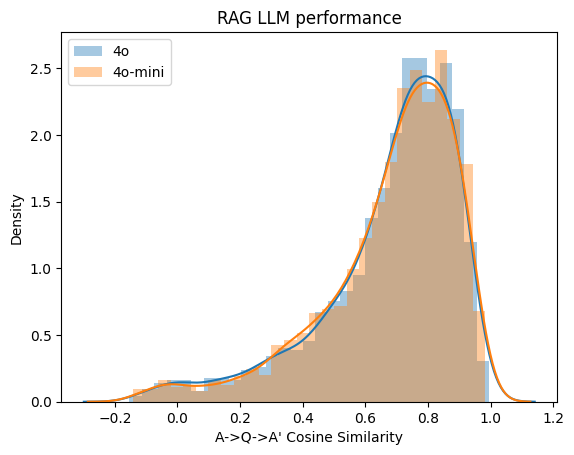

In [250]:
# sns.distplot(df_gpt35['cosine'], label='3.5')

sns.distplot(df_gpt4o['cosine'], label='4o')
sns.distplot(df_gpt4o_mini['cosine'], label='4o-mini')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

## LLM-as-a-Judge

In [234]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [169]:
df_sample = df_gpt4o_mini.sample(n=150, random_state=1)

In [173]:
samples = df_sample.to_dict(orient='records')

In [208]:
record = samples[0]
record

{'answer_llm': 'The syntax for using `precision_recall_fscore_support` in Python is as follows:\n\n```python\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n```',
 'answer_orig': 'Scikit-learn offers another way: precision_recall_fscore_support\nExample:\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n(Gopakumar Gopinathan)',
 'document': '403bbdd8',
 'question': 'What is the syntax for using precision_recall_fscore_support in Python?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.9010756015777588}

In [209]:
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: Scikit-learn offers another way: precision_recall_fscore_support
Example:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)
(Gopakumar Gopinathan)
Generated Question: What is the syntax for using precision_recall_fscore_support in Python?
Generated Answer: The syntax for using `precision_recall_fscore_support` in Python is as follows:

```python
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_

In [210]:
answer = llm(prompt, model='gpt-4o-mini')

In [187]:
import json

In [224]:
evaluations = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations.append(evaluation)

  0%|          | 0/150 [00:00<?, ?it/s]

In [225]:
json_evaluations = []

for i, str_eval in enumerate(evaluations):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

In [227]:
df_evaluations = pd.DataFrame(json_evaluations)

In [228]:
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT           124
PARTLY_RELEVANT     16
NON_RELEVANT        10
Name: count, dtype: int64

In [231]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT'] #.to_dict(orient='records')

,Relevance,Explanation
4,NON_RELEVANT,The generated answer discusses a pip version e...
11,NON_RELEVANT,The generated answer does not address the spec...
27,NON_RELEVANT,The generated answer incorrectly states that t...
41,NON_RELEVANT,The generated answer provides information abou...
87,NON_RELEVANT,The generated answer does not address the orig...
90,NON_RELEVANT,The generated answer responds to a question ab...
93,NON_RELEVANT,The generated answer does not address the topi...
116,NON_RELEVANT,The generated answer discusses the recommended...
138,NON_RELEVANT,The generated answer addresses a different iss...
139,NON_RELEVANT,The generated answer does not relate to the to...


In [232]:
sample[4]

{'answer_llm': "The cause of the pip version error in this week's serverless deep learning section could be a version conflict in Scikit-Learn. Specifically, if you are using a different version than what was used during the model training, it can lead to warnings and potential breaking code or invalid results. To resolve this, make sure to use the same version of Scikit-Learn that was used for training the model. For instance, if you trained with version 1.1.1, you should use that same version in your virtual environment.",
 'answer_orig': 'When running docker build -t dino-dragon-model it returns the above error\nThe most common source of this error in this week is because Alex video shows a version of the wheel with python 8, we need to find a wheel with the version that we are working on. In this case python 9. Another common error is to copy the link, this will also produce the same error, we need to download the raw format:\nhttps://github.com/alexeygrigorev/tflite-aws-lambda/raw

In [235]:
prompt = prompt2_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: What modification was made to the median_house_value target in the homework?
Generated Answer: The modification made to the `median_house_value` target in the homework was that it was changed to binary format. The values were made discrete as either 0 or 1, instead of remaining as a continuous variable. This change was necessary for the calculation of the mutual information score, which is applicable to categorical or discrete variables rather than continuous ones.

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{
  "Relevance": "NON_RELEVANT" | 

In [236]:
evaluation = llm(prompt, model='gpt-4o-mini')
print(evaluation)

{
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer directly addresses the modification made to the `median_house_value` target by clarifying that it was changed to a binary format. It explains the significance of the change and its relation to the calculation of the mutual information score, which is pertinent to understanding the reasons behind the modification."
}


In [237]:
evaluations_2 = []

for record in tqdm(samples):
    prompt = prompt2_template.format(**record)
    evaluation = llm(prompt, model='gpt-4o-mini')
    evaluations_2.append(evaluation)

  0%|          | 0/150 [00:00<?, ?it/s]

In [238]:
json_evaluations_2 = []

for i, str_eval in enumerate(evaluations_2):
    json_eval = json.loads(str_eval)
    json_evaluations_2.append(json_eval)

In [239]:
df_evaluations_2 = pd.DataFrame(json_evaluations_2)

In [242]:
df_evaluations_2[df_evaluations_2.Relevance == 'NON_RELEVANT']

,Relevance,Explanation
45,NON_RELEVANT,The generated answer does not address the ques...
49,NON_RELEVANT,The generated answer explicitly states that th...
139,NON_RELEVANT,The generated answer provides information abou...


In [243]:
samples[45]

{'answer_llm': 'The provided context does not include specific commands to start the Docker daemon on Linux. Therefore, I cannot provide an answer based solely on the facts from the context.',
 'answer_orig': 'Working on getting Docker installed - when I try running hello-world I am getting the error.\nDocker: Cannot connect to the docker daemon at unix:///var/run/docker.sock. Is the Docker daemon running ?\nSolution description\nIf you’re getting this error on WSL, re-install your docker: remove the docker installation from WSL and install Docker Desktop on your host machine (Windows).\nOn Linux, start the docker daemon with either of these commands:\nsudo dockerd\nsudo service docker start\nAdded by Ugochukwu Onyebuchi',
 'document': '4b2a3181',
 'question': 'What commands should I use to start the docker daemon on Linux?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.51130211353302}

## Saving all the data

In [244]:
df_gpt4o.to_csv('data/results-gpt4o-cosine.csv', index=False)
df_gpt35.to_csv('data/results-gpt35-cosine.csv', index=False)
df_gpt4o_mini.to_csv('data/results-gpt4o-mini-cosine.csv', index=False)

In [245]:
df_evaluations.to_csv('data/evaluations-aqa.csv', index=False)
df_evaluations_2.to_csv('data/evaluations-qa.csv', index=False)